# Everest Example

In [1]:
import everest
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
star = everest.Everest(201635569)

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 201635569.


INFO  [everest.user.plot()]: Plotting the light curve...
DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos
DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos
DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos
DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos
DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos
DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos
DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos
DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos


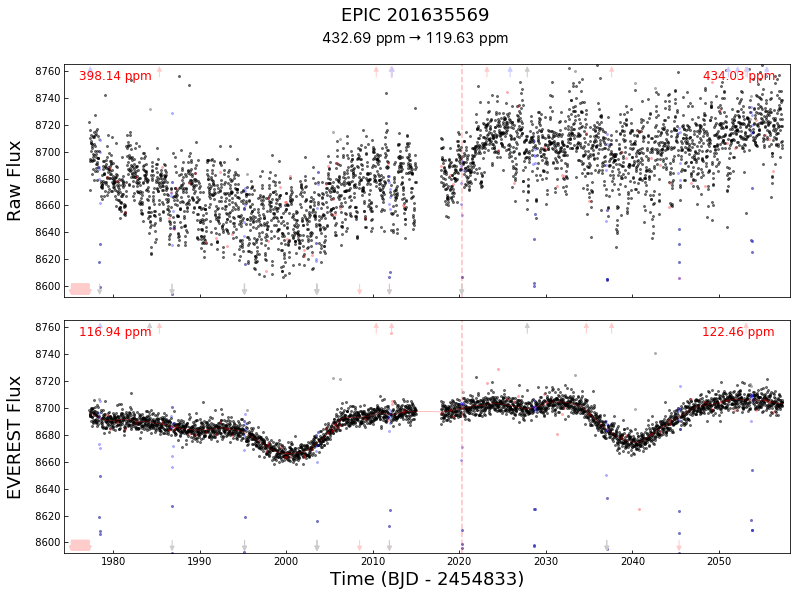

INFO  [everest.user.DownloadFile()]: Downloading the file...


In [34]:
star.plot()
#plt.axvline(1978.4513)

INFO  [everest.basecamp.compute()]: Computing the model...
DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos
DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos
DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos
DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos


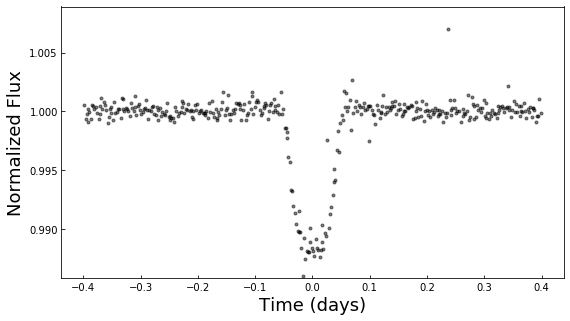

<Figure size 432x288 with 0 Axes>

In [33]:
star.mask_planet(1978.4513, 8.368)
star.compute()
star.plot_folded(1978.4513, 8.368)
plt.savefig('transit.pdf')

In [ ]:
import matplotlib.pyplot as plt

flux_mask = ((star.fcor < 8640)&(star.fcor > 8500))
#x = [star.time[i] for i in range()]
star.time[flux_mask]

#plt.scatter(star.time[flux_mask],star.fcor[flux_mask])

In [ ]:
def lnlike(x, star):
    """Return the log likelihood given parameter vector `x`."""
    per, t0, b = x
    model = TransitModel('b', per=per, t0=t0, b=b)(star.time)
    ll = star.lnlike(model)
    return ll

# MCMC Example
## Fitting a transit model to EPIC 20135569

In [23]:
"""MCMC example for transit fitting."""

import matplotlib.pyplot as pl
from everest import Everest, TransitModel
import numpy as np
import emcee
from tqdm import tqdm_notebook as tqdm
from corner import corner


def lnprior(x):
    """Return the log prior given parameter vector `x`."""
    per = x
    if per < 6 or per > 9:
        return -np.inf
    else:
        return 0.


def lnlike(x):
    """Return the log likelihood given parameter vector `x`."""
    ll = lnprior(x)
    if np.isinf(ll):
        return ll, (np.nan, np.nan)
    per = x
    model = TransitModel('b', per=per, rhos=10.,single=False)(star.time)
    like, d, vard = star.lnlike(model, full_output=True)
    ll += like
    return ll, (d,)


# Initialize the everest model
star = Everest(201505350)

# Set up the MCMC sampler
params = ['Period (days)']
nsteps = 1000
nburn = 300
nwalk = 10
ndim = len(params)

x0 = [[7.9 + 0.01 * np.random.randn()] for k in range(nwalk)]
x1 = 7.9

pos = [7.9 + 1e-4*np.random.randn(ndim) for _ in range(nwalk)]

# Run!
sampler = emcee.EnsembleSampler(nwalk, ndim, lnlike)
sampler.run_mcmc(pos,N=nsteps);
#for i in tqdm(sampler.sample(x0, iterations=nsteps),
 #             total=nsteps):
  #      pass
#from multiprocessing import Pool

#with Pool() as pool:
#    sampler = emcee.EnsembleSampler(nwalk, ndim, lnlike, pool=pool)
#    sampler.run_mcmc(x0, nsteps)
    

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 201505350.


DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos
DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos
DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos
DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos
DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos


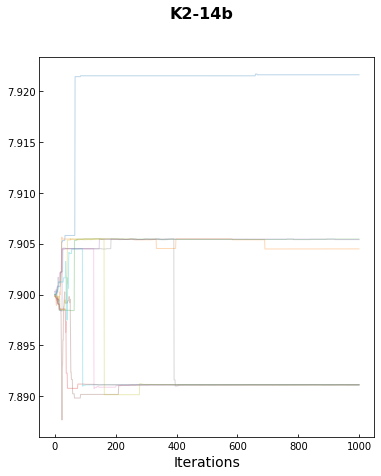

In [28]:
chain = sampler.chain
fig1, ax = pl.subplots(ndim, figsize=(6,7))
fig1.suptitle("K2-14b", fontsize=16, fontweight='bold')
ax.set_xlabel('Iterations', fontsize=14)
for k in range(nwalk):
    ax.plot(chain[k,:], alpha=0.3, lw=1)

In [24]:
# Plot the chains
fig1, ax = pl.subplots(ndim + nblobs, figsize=(6, 7))
fig1.suptitle("K2-14b", fontsize=16, fontweight='bold')
ax[-1].set_xlabel("Iteration", fontsize=14)
for n in range(ndim + nblobs):
    for k in range(nwalk):
        ax[n].plot(chain[k, :, n], alpha=0.3, lw=1)
    ax[n].set_ylabel((params + blobs)[n], fontsize=9)
    ax[n].margins(0, None)
    ax[n].axvline(nburn, color='b', alpha=0.5, lw=1, ls='--')
fig1.savefig("k2-14b_chains.png", bbox_inches='tight')

# Plot the posterior distributions
samples = chain[:, nburn:, :].reshape(-1, ndim + nblobs)
fig2 = corner(samples, labels=params + blobs)
fig2.suptitle("K2-14b", fontsize=16, fontweight='bold')
fig2.set_size_inches(6, 6)
for ax in fig2.axes:
    for tick in ax.get_xticklabels() + ax.get_yticklabels():
        tick.set_fontsize(7)
fig2.savefig("k2-14b_corner.png", bbox_inches='tight')



NameError: name 'nblobs' is not defined

## PyMC implementation

In [5]:
import numpy as np
from astroML.plotting.mcmc import plot_mcmc

import scipy
import scipy.misc
scipy.derivative = scipy.misc.derivative
import pymc

from everest import Everest, TransitModel

def trans_model(per,t0,b,star):
    """Mandel-Agol Model for transits"""
    model = TransitModel('b', per=per, t0=t0, b=b, 
                         rhos=10.)(star.time)
    return model

# Everest object. Holds data
star = Everest(201635569)

# Priors
per = pymc.Uniform('per',7,10,value=8.)
t0 = pymc.Uniform('t0',1977.,1979.,value=1978.)
b = pymc.Uniform('b',-1,1,value=0.)

# PYMC Objects
@pymc.deterministic
def y_model(per=per,t0=t0,b=b,star=star):
    return trans_model(per,t0,b,star)

# Likelihood model
y = pymc.Normal('y', mu=y_model, tau=star.fraw_err ** -2,
                observed=True, value=star.fraw)

model = dict(per=per, t0=t0, b=b, y_model=y_model, y=y)

# Runs MCMC
def compute_MCMC(niter=50000, burn=10000):
    S = pymc.MCMC(model)
    S.sample(iter=niter, burn=burn)
    traces = [S.trace(s)[:] for s in ['per','t0','b']]
    
    M = pymc.MAP(model)
    M.fit()
    
    fit_vals = (M.per.value, M.t0.value, M.b.value)
    
    return traces, fit_vals

traces, fit_vals = compute_MCMC()

print("Maximum a-postreriori parameter estimates")
print('Period: ', fit_vals[0] )
print('t0: ', fit_vals[1] )
print('Transit Depth:', fit_vals[2])

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 201635569.
 [-----------------100%-----------------] 50000 of 50000 complete in 250.9 sec

TypeError: plot() missing 1 required positional argument: 'name'

In [ ]:
from pymc.Matplot import plot
# Plot posteriors

fig = plt.figure(figsize=(7,7))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

labels = ['$Per$','$t_0$','Depth']
#limits = [(7,9),(1950,1990),(-.15,.2)]
plot_mcmc(traces, labels=labels, fig=fig,
          #limits=limits,
          bins=30, color='k')

NameError: name 'M' is not defined

# Initial Data

k2-19 system. 3 planets

In [4]:
k219 = everest.Everest(201505350)

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 201505350.


INFO  [everest.user.plot()]: Plotting the light curve...
DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos
DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos
DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos
DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos
DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos
DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos
DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos
DEBUG [matplotlib.axes._base._update_title_position()]: update_title_pos


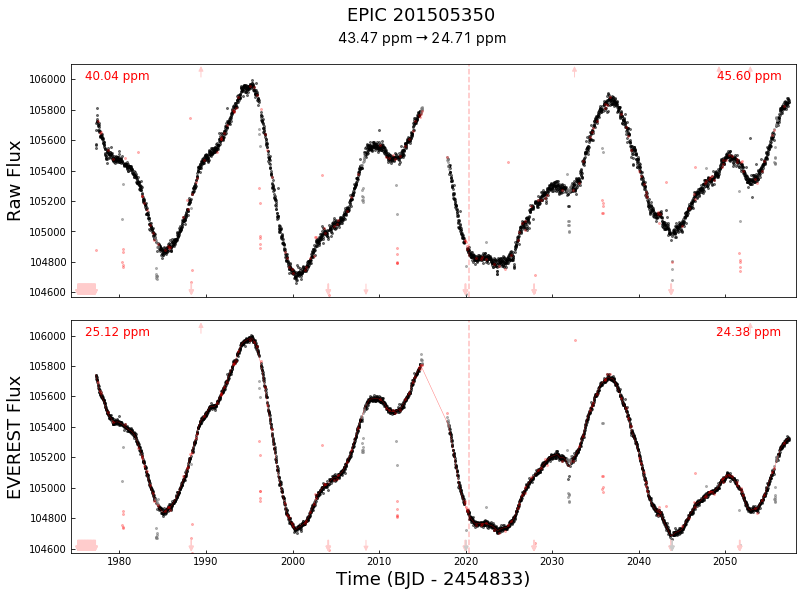

In [6]:
k219.plot(plot_gp=True)

In [ ]:
import matplotlib.pyplot as plt

mask = ((k219.time > 2030)&(k219.time < 2033)&
        (k219.fcor < 105200)&(k219.fcor > 104600))
k219.time[mask]

#plt.scatter(star.time[flux_mask],star.fcor[flux_mask])

In [7]:
star.mask_planet(1985.1, 7.919)
star.compute()
star.plot_folded(1980.1, 7.919)

NameError: name 'star' is not defined

In [44]:
"""MCMC example for transit fitting."""

import matplotlib.pyplot as pl
from everest import Everest, TransitModel
import numpy as np
import emcee
from tqdm import tqdm_notebook as tqdm
from corner import corner


def lnprior(x):
    """Return the log prior given parameter vector `x`."""
    per, t0, b = x
    if b < -1 or b > 1:
        return -np.inf
    elif per < 6 or per > 9:
        return -np.inf
    elif t0 < 1978 or t0 > 1982:
        return -np.inf
    else:
        return 0.


def lnlike(x, star):
    """Return the log likelihood given parameter vector `x`."""
    ll = lnprior(x)
    if np.isinf(ll):
        return ll, (np.nan, np.nan)
    per, t0, b = x
    model = TransitModel('b', per=per, t0=t0, b=b, rhos=10.)(star.time)
    like, d, vard = star.lnlike(model, full_output=True)
    ll += like
    return ll, (d,)


# Initialize the everest model
k219 = everest.Everest(201505350);

# Set up the MCMC sampler
params = ['Period (days)', r't$_0$ (BJD - 2456811)', 'Impact parameter']
blobs = ['Depth (%)']
nsteps = 1000
nburn = 300
nwalk = 10
ndim = len(params)
nblobs = len(blobs)
sampler = emcee.EnsembleSampler(nwalk, ndim, lnlike, args=[k219])
x0 = [[7.9194 + 0.1 * np.random.randn(),
       1980.3837 + 0.01 * np.random.randn(),
       0. + 0.1 * np.random.randn()] for k in range(nwalk)]
blobs0 = [[0.] for k in range(nwalk)]

# Run!
#for i in tqdm(sampler.sample(x0, iterations=nsteps, blobs0=blobs0),
#              total=nsteps):
#        pass
sampler.run_mcmc(x0,N=nsteps);

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 201505350.
emcee: Exception while calling your likelihood function:
  params: [ 7.92031158e+00  1.98037101e+03 -1.20190995e-01]
  args: [<everest.Everest(201505350)>]
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/zllangford/anaconda2/envs/py3/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-44-e349dd3fee81>", line 31, in lnlike
    like, d, vard = star.lnlike(model, full_output=True)
  File "/Users/zllangford/anaconda2/envs/py3/lib/python3.6/site-packages/everest/basecamp.py", line 1165, in lnlike
    lnl += -0.5 * np.dot(r, cho_solve(CDK, r))
  File "/Users/zllangford/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/linalg/decomp_cholesky.py", line 196, in cho_solve
    b1 = asarray_chkfinite(b)
  File "/Users/zllangford/anaconda2/envs/py3/lib/python3.6/site-packages/numpy/lib/function_base.py", line 498, in asarray_chkfinite
    "array must not contain infs or NaNs")
ValueError: array must not contain infs or NaNs


ValueError: array must not contain infs or NaNs

In [ ]:
# Add the blobs to the chain for plotting
chain = np.concatenate((sampler.chain,
                        np.array(sampler.blobs).swapaxes(0, 1)), axis=2)

# Re-scale the transit time for prettier axes labels
chain[:, :, 1] -= 1980.

# Take the absolute value of the impact parameter for plotting
chain[:, :, 2] = np.abs(chain[:, :, 2])

# Re-scale the transit depth as a percentage
chain[:, :, 3] *= 100.

# Plot the chains
fig1, ax = pl.subplots(ndim + nblobs, figsize=(6, 7))
fig1.suptitle("K2-19b", fontsize=16, fontweight='bold')
ax[-1].set_xlabel("Iteration", fontsize=14)
for n in range(ndim + nblobs):
    for k in range(nwalk):
        ax[n].plot(chain[k, :, n], alpha=0.3, lw=1)
    ax[n].set_ylabel((params + blobs)[n], fontsize=9)
    ax[n].margins(0, None)
    ax[n].axvline(nburn, color='b', alpha=0.5, lw=1, ls='--')
fig1.savefig("k2-19b_chains.png", bbox_inches='tight')

# Plot the posterior distributions
samples = chain[:, nburn:, :].reshape(-1, ndim + nblobs)
fig2 = corner(samples, labels=params + blobs)
fig2.suptitle("K2-19b", fontsize=16, fontweight='bold')
fig2.set_size_inches(6, 6)
for ax in fig2.axes:
    for tick in ax.get_xticklabels() + ax.get_yticklabels():
        tick.set_fontsize(7)
fig2.savefig("k2-19b_corner.png", bbox_inches='tight')

In [10]:
np.random.randn()

0.037076230862751976

In [ ]:
bias_data = [CCDData.read(filename,unit='adu') for filename in bias_list]

In [36]:
2456813.3837 - 2454833

1980.3837000001222

In [ ]:
star = everest.Everest(201635569)